# IBM Data Science Certificate Capstone Project

## Introduction

The Bay Area has been experiencing a mass exodus of Big Tech companies in recent years. In 2020, California suffered the largest outflow of residents among all 50 states and ranked last for migration growth. This phenomenon has been exacerbated by the growth of remote working opportunities due to the COVID-19 pandemic, high rents, skyrocketing cost of living, and long commutes. Tech giants, such as Apple, Google, Salesforce, and Twitter have sent their employees home to work remotely, allowing workers to look for cheaper alternative cities. Additionally, businesses in California are also looking for alternative locations for their company headquarters due to high corporate and income taxes. Companies like Oracle and Hewlett Packard Enterprise have moved their entire headquarters to Texas.

Austin, Texas has emerged as one of the most popular alternative destinations for workers and businesses moving out of the Bay Area. Austin offers significantly lower housing costs, property taxes, cost of living, and state income taxes.

People moving to new locations face many difficulties. Especially during a pandemic, it may be impossible to visit the location prior to deciding where to live. Moreover, if people are having to move abruptly due to their employment situation, people may not have enough time to consider all the variables to take into account when choosing their new home. Many people could also face hardships adjusting to their new environment if the changes are too drastic. Therefore, the neighborhood to which one migrates can be a huge factor in whether people have a positive experience adjusting to their new lifestyle.

**Target Audience:** 

1. San Francisco residents looking to move to Austin. 
2. Austin residents looking to move to San Francisco. 
3. Anyone deciding between Austin and San Francisco. 

## Data 

This analysis aims to solve the issue of finding the best alternative neighborhood for Bay Area residents looking to move to Austin, Texas. The different types of venues available in the vicinity of the neighborhood will be considered to group similar neighborhoods between San Francisco, California, and Austin, Texas. 

### Data Sources 
We will be using geospatial data from [SF Open Data Portal](https://data.sfgov.org/Geographic-Locations-and-Boundaries/SF-Find-Neighborhoods/pty2-tcw4) and [Austin Open Data Portal](https://data.austintexas.gov/Building-and-Development/Neighborhoods/a7ap-j2yt) to obtain the coordinates of the centroid for each neighborhood. 

We will obtain venue data for each neighborhood from the [Foursquare API](https://developer.foursquare.com/docs/places-api/endpoints/). I will download the top 100 venues located in 1 mile radius around each neighborhood using the API. 



#### Importing libraries

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt

import requests 
import json 
import matplotlib.cm as cm
import matplotlib.colors as colors

from pandas.io.json import json_normalize 
from sklearn.cluster import KMeans

#!pip install shapely
from shapely.wkt import loads as load_wkt

#### Import neighborhoods coordinates data

First, we need to obtain the full list of all neighborhoods in San Francisco and Austin. I downloaded the neighborhood geospatial data from  SF Open Data Portal and Austin Open Data Portal as `csv` files to this repository.  

In [2]:
# Importing the neighborhoods data
sf_df = pd.read_csv("sf_neighborhood.csv")
austin_df = pd.read_csv("austin_neighborhood.csv")

#### Data Cleaning

[Shapely](https://pypi.org/project/Shapely/) is a Python package for manipulation and analysis of planar geometric objects. We will use it to calculate the coordinates from the `MULTIPOLYGON` geometry of the neighborhoods. This will allow us to more accurately obtain the venues data later on in the investigation since the Foursquare API will be collecting venues data within a set radius around the coordinate provided. Therefore, using the centroid of the neighborhood geometries would be appropriate. 

In [3]:
col_names = ["Neighborhood", "Latitude", "Longitude", "Geometry"]

# Calculating the coordinates from the centroid of the MULTIPOLYGON
sf_df["longitude"] = sf_df.apply(lambda row: load_wkt(row.the_geom).centroid.x, axis = 1)
sf_df["latitude"] = sf_df.apply(lambda row: load_wkt(row.the_geom).centroid.y, axis = 1)
sf_df = sf_df[["name", "latitude", "longitude","the_geom"]]
sf_df.columns = col_names

# Making the neighborhood names all upper case for consistency
sf_df["Neighborhood"] = sf_df["Neighborhood"].str.upper()

# Assign city to each neighborhood in order to distinguish from neighborhoods in Austin
san_francisco = ["San Francisco"] * len(sf_df)
sf_df.insert(loc = 0, column = "City", value = san_francisco)

print(sf_df.shape)
sf_df.head()

(117, 5)


,City,Neighborhood,Latitude,Longitude,Geometry
0,San Francisco,SEACLIFF,37.786803,-122.488844,MULTIPOLYGON (((-122.49345526799993 37.7835181...
1,San Francisco,LAKE STREET,37.785513,-122.479626,MULTIPOLYGON (((-122.48715071499993 37.7837854...
2,San Francisco,PRESIDIO NATIONAL PARK,37.797416,-122.466434,MULTIPOLYGON (((-122.47758017099994 37.8109931...
3,San Francisco,PRESIDIO TERRACE,37.787007,-122.464250,MULTIPOLYGON (((-122.47241052999993 37.7873465...
4,San Francisco,INNER RICHMOND,37.779374,-122.468504,MULTIPOLYGON (((-122.47262578999994 37.7863148...


Let's examine dataframe created for San Francisco. We can see that there are 117 neighborhoods in San francisco and the coordinates have been successfully extrated.

Now we repeat the same process for Austin. 

In [4]:
# Calculating the coordinates from the centroid of the MULTIPOLYGON
austin_df["longitude"] = austin_df.apply(lambda row: load_wkt(row.the_geom).centroid.x, axis = 1)
austin_df["latitude"] = austin_df.apply(lambda row: load_wkt(row.the_geom)
                                        .centroid.y, axis = 1)
austin_df = austin_df[["NEIGHNAME", "latitude", "longitude", "the_geom"]]
austin_df.columns = col_names

# Assign city to each neighborhood in order to distinguish from neighborhoods in Austin
austin = ["Austin"] * len(austin_df)
austin_df.insert(loc = 0, column = "City", value = austin)

print(austin_df.shape)
austin_df.head()

(103, 5)


,City,Neighborhood,Latitude,Longitude,Geometry
0,Austin,ANDERSON MILL,30.441196,-97.809771,MULTIPOLYGON (((-97.792307359674 30.4567073495...
1,Austin,WINDSOR PARK,30.311575,-97.692326,MULTIPOLYGON (((-97.670762852964 30.3085399639...
2,Austin,DAWSON,30.232695,-97.761797,MULTIPOLYGON (((-97.753526659646 30.2387648363...
3,Austin,WEST UNIVERSITY,30.291838,-97.745308,MULTIPOLYGON (((-97.738154269236 30.3027463827...
4,Austin,MLK,30.283831,-97.692304,MULTIPOLYGON (((-97.682624533084 30.2858668623...


We can see that Austin has 103 neighborhoods and the coordinates have been successfully extracted. 

In [5]:
austin_df.shape

(103, 5)

#### Obtain coordinate for each city

Next we will be using the *Geocoding API* to obtain the geolocation data for the cities. Please refer to [Geocoding Developer Guide](https://developers.google.com/maps/documentation/geocoding/overview) for more information. 

In [6]:
#!pip install geocoder
import geocoder
from geopy.geocoders import Nominatim 

geolocator = Nominatim(user_agent="sf_explorer")
location_austin = geolocator.geocode("Austin, TX")
latitude_austin = location_austin.latitude
longitude_austin = location_austin.longitude
print('The geograpical coordinate of Austin are {}, {}.'.format(latitude_austin, longitude_austin))


geolocator = Nominatim(user_agent="sf_explorer")
location_sf = geolocator.geocode("San Francisco, California")
latitude_sf = location_sf.latitude
longitude_sf = location_sf.longitude
print('The geograpical coordinate of San Francisco are {}, {}.'.format(latitude_sf, longitude_sf))

The geograpical coordinate of Austin are 30.2711286, -97.7436995.
The geograpical coordinate of San Francisco are 37.7790262, -122.4199061.


#### Geospatial Visualization

We will use the [Mapbox Maps](https://plotly.com/python/mapbox-layers/) visualization library and [Plotly](https://plotly.com/) graphing library to display and confirm that the coordinates for each neighborhood were extracted correctly. 

In [42]:
import plotly.graph_objects as go

mapbox_access_token = "pk.eyJ1IjoiamV3b25qdTk3IiwiYSI6ImNrbTdjZDd5ejB3aDUycm85b282YzE1amIifQ.9V1vCbjDFvMCrqgg_gQi3A"

fig = go.Figure()

fig.add_trace(go.Scattermapbox(lat = sf_df["Latitude"], 
                               lon = sf_df["Longitude"],
                               mode = "markers", 
                               marker = go.scattermapbox.Marker(
                                   size = 5, color = "blue", opacity = 0.7),
                               text = sf_df["Neighborhood"], 
                               hoverinfo = "text"))

fig.update_layout(
    title='San Francisco Neighborhoods',
    autosize=False,
    width = 1000,
    height = 800, 
    hovermode='closest',
    showlegend=False,
    mapbox=dict(
        accesstoken=mapbox_access_token,
        bearing=0,
        center=dict(
            lat=latitude_sf,
            lon=longitude_sf
        ),
        pitch=0,
        zoom=11.2,
        style='light'
    ),
)

fig.show()


In [43]:
fig = go.Figure()



fig.add_trace(go.Scattermapbox(lat = austin_df["Latitude"], 
                               lon = austin_df["Longitude"],
                               mode = "markers", 
                               marker = go.scattermapbox.Marker(
                                   size = 5, color = "red", opacity = 0.7),
                               text = austin_df["Neighborhood"], 
                               hoverinfo = "text"))

fig.update_layout(
    title='Austin Neighborhoods',
    autosize=False,
    width = 1000,
    height = 800, 
    hovermode='closest',
    showlegend=False,
    mapbox=dict(
        accesstoken=mapbox_access_token,
        bearing=0,
        center=dict(
            lat=latitude_austin,
            lon=longitude_austin
        ),
        pitch=0,
        zoom=10,
        style='light'
    ),
)

fig.show()


We can see that the neighborhood coordinates were successfully extract for both cities. 

## Venues Data (Foursquare API)

#### Define Foursquare Credentials and Version

We will use the [Foursquare API](https://developer.foursquare.com/) to obtain the venues data for our analysis. 

In [9]:
CLIENT_ID = 'MWFK5JBUHA0B1IG50UJ4AWAKWEYIZ4JZF4B1RAT4OX5L1RVQ' # my Foursquare ID
CLIENT_SECRET = '31KCNG2OMYZPI20PP50SKIUOGF4PROEC5UD3OIIDK2QERT44' # my Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Credentails:
CLIENT_ID: MWFK5JBUHA0B1IG50UJ4AWAKWEYIZ4JZF4B1RAT4OX5L1RVQ
CLIENT_SECRET:31KCNG2OMYZPI20PP50SKIUOGF4PROEC5UD3OIIDK2QERT44


We will be using different radius for each cities to collect the venues data since there is a significant difference in the area of San Francisco and Austin. The area of San Francisco is 46.87 mi² whereas the area of Austin is 271.8 mi². 

Therefore, we will calculate the average radius of neighborhoods by dividing the total area of the city by the number of neighborhoods and using the formula for area of circle. Although, we will have to be mindful that we are making the assumption that the neighborhoods are all shaped like a circle and that the distribution of neighborhood areas is rather uniform. 

In [10]:
# Calculating the average radius of the neighborhoods for each city
sf_radius = np.sqrt(46.87 / len(sf_df) / np.pi) * 1.61 *1000
austin_radius = np.sqrt(271.8 / len(austin_df) / np.pi) * 1.61 *1000

print('The average radius of San Francisco Neighborhoods is {}.'.format(sf_radius))
print('The average radius of Austin Neighborhoods is {}.'.format(austin_radius))

The average radius of San Francisco Neighborhoods is 574.9174433014938.
The average radius of Austin Neighborhoods is 1475.5606109699843.


Looking at this result, we will be using 600m as the radius for San Francisco and 1500m as the radius for Austin. 

### Converting subcategories into top-level categories

[Foursquare API](https://developer.foursquare.com/docs/api-reference/venues/search/) provides information about venues and geolocation. The API call returns a list of venues near the specified coordinates and radius. We are most interested in the categories of the venues for our analysis. However, the venue category returned only contains the subcategories. This could be problematic for cluster analysis because there may be too many unique venue subcategories that make it difficult for the algorithm to cluster the neighborhoods into meaningful clusters. As a result, we have to convert the subcategories into top-level categories.

In [11]:
categories_url = 'https://api.foursquare.com/v2/venues/categories?client_id={}&client_secret={}&v={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
            
# make the GET request
results = requests.get(categories_url).json()

We can see that there are 10 top-level categories that we can use to cluster neighborhoods together. 

In [12]:
categories_list = []

# Let's print only the top-level categories and their IDs and also add them to categories_list

def print_categories(categories, level=0, max_level=0):    
    if level>max_level: return
    out = ''
    out += '-'*level
    for category in categories:
        print(out + category['name'] + ' (' + category['id'] + ')')
        print_categories(category['categories'], level+1, max_level)
        categories_list.append((category['name'], category['id']))
        
print_categories(results['response']['categories'], 0, 0)

Arts & Entertainment (4d4b7104d754a06370d81259)
College & University (4d4b7105d754a06372d81259)
Event (4d4b7105d754a06373d81259)
Food (4d4b7105d754a06374d81259)
Nightlife Spot (4d4b7105d754a06376d81259)
Outdoors & Recreation (4d4b7105d754a06377d81259)
Professional & Other Places (4d4b7105d754a06375d81259)
Residence (4e67e38e036454776db1fb3a)
Shop & Service (4d4b7105d754a06378d81259)
Travel & Transport (4d4b7105d754a06379d81259)


#### Recursively sorting subcategories

We will create a dataframe containing information about the subcategories and their corresponding top-level categories. We will later use this dataframe to assign top-level categories to our dataframe containg venues data for the neighborhoods.

https://gist.github.com/Zoltrix/d69a52e9f91f4211be93eea1f1398424

In [13]:
SUBCATEGORIES = {}

def subcategorize(cat, prev):
    if cat.get('categories', False):
        
        lvl = len(prev)-1
        for subcat in cat['categories']:
            
            child = subcat['name']
            subcategorize(subcat, prev+[child])
            if child not in SUBCATEGORIES:
                SUBCATEGORIES[child] = [(prev[0], 0)]
                
            #for i in range(1, lvl+1):
                #SUBCATEGORIES[child].append((prev[i], i))
                
for cat in results['response']['categories']:
    name = cat['name']
    subcategorize(cat, [name])
    
venue_categories = pd.DataFrame(columns = ['Venue Category', 'Category'])
for k, v in SUBCATEGORIES.items():
    for sub, lvl in v:
        venue_categories.loc[len(venue_categories)] = (k, sub)
        
venue_categories.head()

,Venue Category,Category
0,Amphitheater,Arts & Entertainment
1,Aquarium,Arts & Entertainment
2,Arcade,Arts & Entertainment
3,Art Gallery,Arts & Entertainment
4,Bowling Alley,Arts & Entertainment


In [14]:
# Check if the sorting was done correctly
venue_categories["Category"].unique()

array(['Arts & Entertainment', 'College & University', 'Event', 'Food',
       'Nightlife Spot', 'Outdoors & Recreation',
       'Professional & Other Places', 'Residence', 'Shop & Service',
       'Travel & Transport'], dtype=object)

#### Define a function to scrape the venues near each neighborhoods

Now we use the Foursquare API to ontain the venues data for each neighborhood. 

In [15]:
def getNearbyVenues(cities, names, latitudes, longitudes, radius):
    
    venues_list=[]
    for city, name, lat, lng in zip(cities, names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius,
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            city,
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['City',
                  'Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [16]:
sf_venues = getNearbyVenues(cities=sf_df['City'], 
                                   names=sf_df['Neighborhood'],
                                   latitudes=sf_df['Latitude'],
                                   longitudes=sf_df['Longitude'],
                                    radius = 600
                                  )

SEACLIFF
LAKE STREET
PRESIDIO NATIONAL PARK
PRESIDIO TERRACE
INNER RICHMOND
SUTRO HEIGHTS
LINCOLN PARK / FT. MILEY
OUTER RICHMOND
GOLDEN GATE PARK
PRESIDIO HEIGHTS
LAUREL HEIGHTS / JORDAN PARK
LONE MOUNTAIN
ANZA VISTA
COW HOLLOW
UNION STREET
NOB HILL
MARINA
TELEGRAPH HILL
DOWNTOWN / UNION SQUARE
TENDERLOIN
CIVIC CENTER
HAYES VALLEY
ALAMO SQUARE
PANHANDLE
HAIGHT ASHBURY
LOWER HAIGHT
MINT HILL
DUBOCE TRIANGLE
COLE VALLEY
RINCON HILL
SOUTH BEACH
SOUTH OF MARKET
SHOWPLACE SQUARE
MISSION BAY
YERBA BUENA ISLAND
TREASURE ISLAND
MISSION DOLORES
CASTRO
OUTER SUNSET
PARKSIDE
STONESTOWN
PARKMERCED
LAKESHORE
GOLDEN GATE HEIGHTS
FOREST HILL
WEST PORTAL
CLARENDON HEIGHTS
MIDTOWN TERRACE
LAGUNA HONDA
LOWER NOB HILL
UPPER MARKET
DOLORES HEIGHTS
MISSION
POTRERO HILL
DOGPATCH
CENTRAL WATERFRONT
DIAMOND HEIGHTS
CROCKER AMAZON
FAIRMOUNT
PERALTA HEIGHTS
HOLLY PARK
MERCED MANOR
BALBOA TERRACE
INGLESIDE
MERCED HEIGHTS
OUTER MISSION
INGLESIDE TERRACES
MT. DAVIDSON MANOR
MONTEREY HEIGHTS
WESTWOOD HIGHLANDS
WES

In [17]:
print(sf_venues.shape)
sf_venues.head()

(5773, 8)


,City,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,San Francisco,SEACLIFF,37.786803,-122.488844,China Beach,37.788090,-122.491186,Beach
1,San Francisco,SEACLIFF,37.786803,-122.488844,Seacliff,37.788259,-122.486401,Neighborhood
2,San Francisco,SEACLIFF,37.786803,-122.488844,Eagles Point,37.786714,-122.494810,Scenic Lookout
3,San Francisco,SEACLIFF,37.786803,-122.488844,Lincoln Park Stairs,37.783496,-122.493597,Trail
4,San Francisco,SEACLIFF,37.786803,-122.488844,Rochambeau Playground,37.784892,-122.484309,Playground


In [18]:
austin_venues = getNearbyVenues(cities=austin_df['City'],
                                names=austin_df['Neighborhood'],
                                   latitudes=austin_df['Latitude'],
                                   longitudes=austin_df['Longitude'],
                                    radius=1500
                                  )

ANDERSON MILL
WINDSOR PARK
DAWSON
WEST UNIVERSITY
MLK
SOUTH RIVER CITY
MLK-183
OLD WEST AUSTIN
BOULDIN CREEK
WALNUT CREEK--PIONEER HILL
SOUTHEAST
UNIVERSITY HILLS
WINDSOR ROAD
JESTER
CIRCLE C SOUTH
WESTGATE
GALINDO
BRODIE LANE
HYDE PARK
MCKINNEY
WESTOVER HILLS
GRACY WOODS
PLEASANT VALLEY
SOUTH LAMAR
PECAN SPRINGS-SPRINGDALE
FOUR POINTS
POND SPRINGS
ST. EDWARDS
UT
HIGHLAND
DOWNTOWN
HANCOCK
DITTMAR--SLAUGHTER
TECH RIDGE
SAMSUNG--PIONEER CROSSING
WEST AUSTIN NG
BLUFF SPRINGS
MONTOPOLIS
CHERRY CREEK
BARTON HILLS
GATEWAY
WOOTEN
HOLLY
GARRISON PARK
MANSFIELD--RIVER PLACE
GEORGIAN ACRES
EAST CESAR CHAVEZ
NORTH LOOP
MCNEIL
RMMA
DAVENPORT LAKE AUSTIN
ZILKER
HAYS WARTHA
LBJ
WEST CONGRESS
VILLAGE AT WESTERN OAKS
DEL VALLE
ROBINSON RANCH
BULL CREEK
HERITAGE HILLS
OLD ENFIELD
CHESTNUT
ROSEDALE
DEL VALLE EAST
NORTH BURNET
BERGSTROM
SOUTH BRODIE
DECKER LAKE
GOVALLE
NORTH SHOAL CREEK
RIVERSIDE
UPPER BOGGY CREEK
WEST OAK HILL
CORONADO HILLS
WHISPER VALLEY
ONION CREEK
NORTH LAMAR RUNDBERG
HIGHLAND PARK


In [19]:
print(austin_venues.shape)
austin_venues.head()

(5935, 8)


,City,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Austin,ANDERSON MILL,30.441196,-97.809771,Punch Austin Kettlebell Gym,30.447413,-97.810296,Gym / Fitness Center
1,Austin,ANDERSON MILL,30.441196,-97.809771,Speedy Mart,30.447440,-97.804303,Food & Drink Shop
2,Austin,ANDERSON MILL,30.441196,-97.809771,Trailhead Park,30.438613,-97.821124,Park
3,Austin,ANDERSON MILL,30.441196,-97.809771,Millrun Park,30.451548,-97.802975,Park
4,Austin,ANDERSON MILL,30.441196,-97.809771,YoCup Frozen Yogurt,30.447489,-97.810668,Frozen Yogurt Shop


In [20]:
# Join the two dataframes 
venues = pd.concat([sf_venues, austin_venues], ignore_index=True)

print(venues.shape)

venues.head()

(11708, 8)


,City,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,San Francisco,SEACLIFF,37.786803,-122.488844,China Beach,37.788090,-122.491186,Beach
1,San Francisco,SEACLIFF,37.786803,-122.488844,Seacliff,37.788259,-122.486401,Neighborhood
2,San Francisco,SEACLIFF,37.786803,-122.488844,Eagles Point,37.786714,-122.494810,Scenic Lookout
3,San Francisco,SEACLIFF,37.786803,-122.488844,Lincoln Park Stairs,37.783496,-122.493597,Trail
4,San Francisco,SEACLIFF,37.786803,-122.488844,Rochambeau Playground,37.784892,-122.484309,Playground


#### Assign top-level categories

In [21]:
venues = pd.merge(venues, venue_categories, on= "Venue Category", how = 'left')

print(venues.shape)
venues.head()

(11708, 9)


,City,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Category
0,San Francisco,SEACLIFF,37.786803,-122.488844,China Beach,37.788090,-122.491186,Beach,Outdoors & Recreation
1,San Francisco,SEACLIFF,37.786803,-122.488844,Seacliff,37.788259,-122.486401,Neighborhood,Outdoors & Recreation
2,San Francisco,SEACLIFF,37.786803,-122.488844,Eagles Point,37.786714,-122.494810,Scenic Lookout,Outdoors & Recreation
3,San Francisco,SEACLIFF,37.786803,-122.488844,Lincoln Park Stairs,37.783496,-122.493597,Trail,Outdoors & Recreation
4,San Francisco,SEACLIFF,37.786803,-122.488844,Rochambeau Playground,37.784892,-122.484309,Playground,Outdoors & Recreation


In [22]:
print("There are {} unique sub-categories of venues.".format(len(venues["Venue Category"].unique())))
print("There are {} unique categories of venues.".format(len(venues["Category"].unique())))

There are 466 unique sub-categories of venues.
There are 10 unique categories of venues.


## Exploratory Data Analysis

In [45]:
# One hot encoding 
venues_onehot = pd.get_dummies(venues[['Category']], prefix="", prefix_sep="")

# add city and neighborhood column back to dataframe
venues_onehot['City'] = venues['City'] 
venues_onehot['Neighborhood'] = venues['Neighborhood'] 

# move city and neighborhood column to the first column
fixed_columns = [venues_onehot.columns[-1]] + list(venues_onehot.columns[:-1])
venues_onehot = venues_onehot[fixed_columns]
fixed_columns = [venues_onehot.columns[-1]] + list(venues_onehot.columns[:-1])
venues_onehot = venues_onehot[fixed_columns]

print(venues_onehot.shape)
venues_onehot.head()

(11708, 11)


,City,Neighborhood,Arts & Entertainment,College & University,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport
0,San Francisco,SEACLIFF,0,0,0,0,1,0,0,0,0
1,San Francisco,SEACLIFF,0,0,0,0,1,0,0,0,0
2,San Francisco,SEACLIFF,0,0,0,0,1,0,0,0,0
3,San Francisco,SEACLIFF,0,0,0,0,1,0,0,0,0
4,San Francisco,SEACLIFF,0,0,0,0,1,0,0,0,0


#### Comparison between Austin and San Francisco

In [46]:
city_grouped = venues_onehot.groupby('City').sum().reset_index()
city_grouped = city_grouped.set_index('City').transpose()
city_grouped

City,Austin,San Francisco
Arts & Entertainment,246.0,282.0
College & University,14.0,7.0
Food,2735.0,2633.0
Nightlife Spot,368.0,430.0
Outdoors & Recreation,598.0,861.0
Professional & Other Places,40.0,76.0
Residence,10.0,3.0
Shop & Service,1674.0,1291.0
Travel & Transport,241.0,184.0


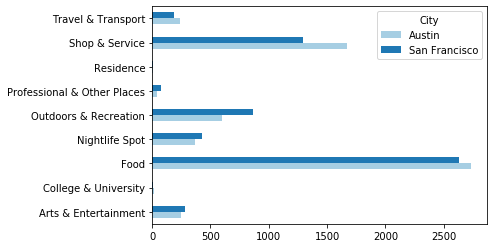

In [47]:
city_grouped.plot.barh()

### Boxplot of Venues Categories

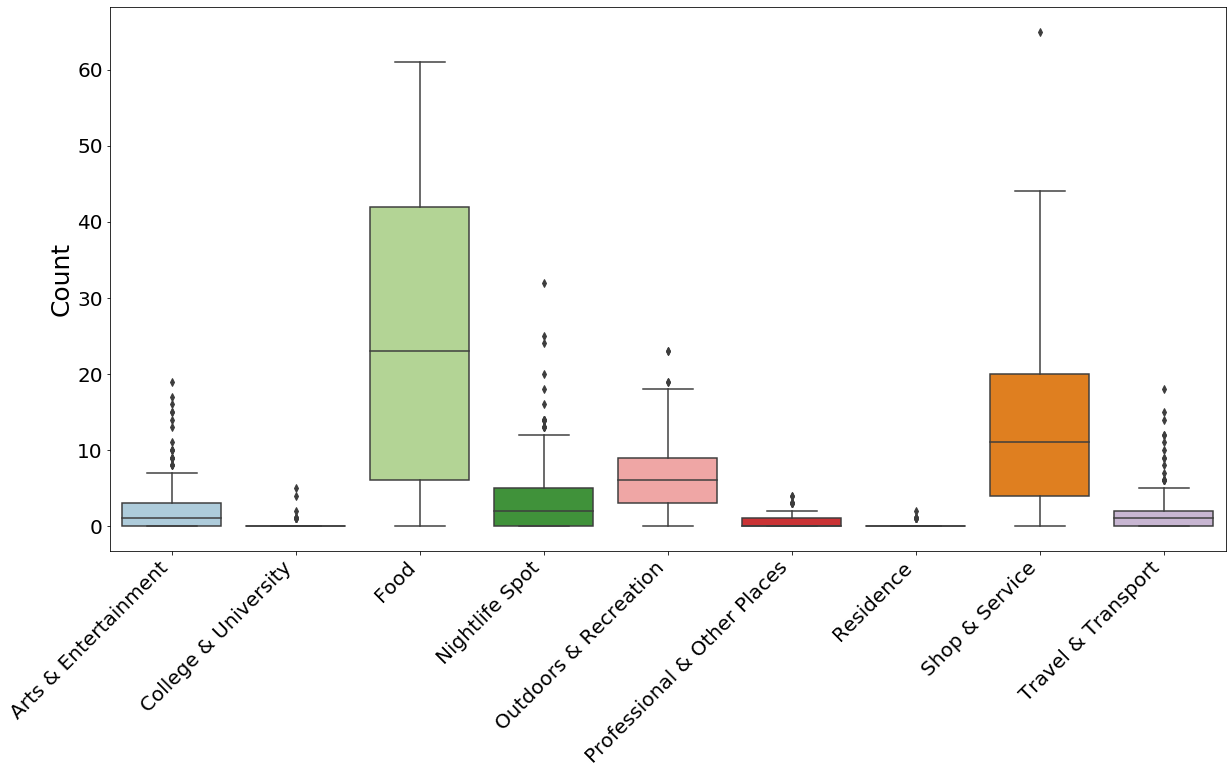

In [48]:
import seaborn as sns

%matplotlib inline 

venues_grouped = venues_onehot.groupby('Neighborhood').sum().reset_index()

plt.figure(figsize=(20,10))
plt.xticks(rotation= 'vertical')

ax = sns.boxplot(data= venues_grouped)

ax.set_ylabel('Count', fontsize=25)
ax.set_xlabel('', fontsize=25)
ax.tick_params(labelsize=20)
plt.xticks(rotation=45, ha='right')

sns.set_palette("Paired", 9)

plt.show()

Notice there are only 9 different top-level venue categories displayed in the boxplot. This is because there was no venue classified as Event venue in either of the cities. 

We can observe that **Food** venues have the highest median count as well as the largest variability. This is followed by **Shop & Service** venues. 

**Art & Entertainment**, **Nightlife Spot**, and **Travel & Transport** venues have the most significant outliers. 

We will be omitting **College & University** and **Residence** venues from the analysis since the number of neighborhoods with those venues are comparatively low. 

In [49]:
# Drop College & University and Residence as their counts are marginal 
venues_onehot = venues_onehot.drop(["College & University", "Residence"], 1)

## Methodology

### K-Means Clustering Analysis

We will perform a clustering analysis using the ["k-means"](https://en.wikipedia.org/wiki/K-means_clustering) algorithm to categorize similar neighborhoods into clusters based on their similarities in the types of venues present near the neighborhood. 

In [50]:
from sklearn.cluster import KMeans
import sklearn.cluster.k_means_
from sklearn.preprocessing import MinMaxScaler

In [51]:
venues_grouped_clustering = venues_onehot.drop(['Neighborhood', 'City'], 1)

mms = MinMaxScaler()

venues_transformed = mms.fit(venues_grouped_clustering).transform(venues_grouped_clustering)


#### Determining the optimal k using the Elbow Method

A frequent problem in data clustering is determining the number of clusters (*k*) in a data set. The correct choice of *k* is often ambiguous. Increasing the number of clusters improves the ability of the algorithm to explain more of the variation in the data. However, this could result in *over-fitting* of the data and increase the difficulty of interpreting the result of the clustering. 

As a result, we will be using the [Elbow method](https://en.wikipedia.org/wiki/Elbow_method_(clustering)) to determine the optimal *k* for k-means clustering algorithm. We will be choosing the point where the diminishing returns are no longer worth the additional cost of additional cluster. We will be generating a plot of sum of squared distances for k in the specified range of ks, 15 in our case. If the plot ends up looking like an arm, then the optimal *k* is the elbow of the arm. 

In [52]:
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(venues_transformed)
    Sum_of_squared_distances.append(km.inertia_)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:972: ConvergenceWarning:

Number of distinct clusters (8) found smaller than n_clusters (9). Possibly due to duplicate points in X.

/opt/anaconda3/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:972: ConvergenceWarning:

Number of distinct clusters (8) found smaller than n_clusters (10). Possibly due to duplicate points in X.

/opt/anaconda3/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:972: ConvergenceWarning:

Number of distinct clusters (8) found smaller than n_clusters (11). Possibly due to duplicate points in X.

/opt/anaconda3/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:972: ConvergenceWarning:

Number of distinct clusters (8) found smaller than n_clusters (12). Possibly due to duplicate points in X.

/opt/anaconda3/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:972: ConvergenceWarning:

Number of distinct clusters (8) found smaller than n_clusters (13). Possibly due to 

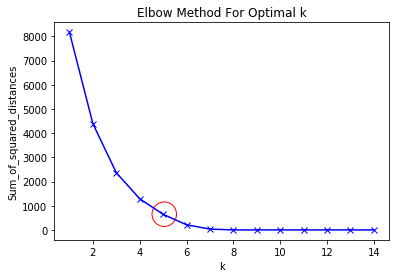

In [54]:
fig, ax = plt.subplots()

plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')

# Add red circle to point out the optimal k
plt.scatter( 5.05 , 650 , s = 600, facecolors='none', edgecolors='r' ) 

plt.show()

Looking that the plot above, the elbow occurs at k=5. Therefore, we will be using the *k-means* clustering analysis using 5 clusters.

In [55]:
venues_grouped_clustering = venues_grouped.drop('Neighborhood', 1)

# set number of clusters
kclusters = 5

#venues_grouped_clustering = venues_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=1).fit(venues_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([2, 3, 0, 4, 4, 4, 0, 4, 0, 3], dtype=int32)

In [56]:
# merge sf_df and austin_df
df_merged = pd.concat([sf_df, austin_df], ignore_index=True)

df_merged["Neighborhood"] = df_merged["Neighborhood"].str.upper()

print(df_merged.shape) 
df_merged.head()

(220, 5)


,City,Neighborhood,Latitude,Longitude,Geometry
0,San Francisco,SEACLIFF,37.786803,-122.488844,MULTIPOLYGON (((-122.49345526799993 37.7835181...
1,San Francisco,LAKE STREET,37.785513,-122.479626,MULTIPOLYGON (((-122.48715071499993 37.7837854...
2,San Francisco,PRESIDIO NATIONAL PARK,37.797416,-122.466434,MULTIPOLYGON (((-122.47758017099994 37.8109931...
3,San Francisco,PRESIDIO TERRACE,37.787007,-122.464250,MULTIPOLYGON (((-122.47241052999993 37.7873465...
4,San Francisco,INNER RICHMOND,37.779374,-122.468504,MULTIPOLYGON (((-122.47262578999994 37.7863148...


In [57]:
# add clustering labels
venues_grouped.insert(0, 'Cluster Labels', kmeans.labels_)

venues_grouped["Cluster Labels"] += 1


venues_grouped = venues_grouped.set_index('Neighborhood')

# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
df_merged = df_merged.join(venues_grouped, on='Neighborhood')

df_merged = df_merged.drop(["College & University", "Residence"], 1)

df_merged=df_merged.dropna()
df_merged['Cluster Labels'] = df_merged["Cluster Labels"].astype(int)

df_merged.head() # check the last columns!

,City,Neighborhood,Latitude,Longitude,Geometry,Cluster Labels,Arts & Entertainment,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Shop & Service,Travel & Transport
0,San Francisco,SEACLIFF,37.786803,-122.488844,MULTIPOLYGON (((-122.49345526799993 37.7835181...,1,0.0,6.0,0.0,7.0,0.0,0.0,0.0
1,San Francisco,LAKE STREET,37.785513,-122.479626,MULTIPOLYGON (((-122.48715071499993 37.7837854...,3,1.0,48.0,0.0,6.0,1.0,14.0,0.0
2,San Francisco,PRESIDIO NATIONAL PARK,37.797416,-122.466434,MULTIPOLYGON (((-122.47758017099994 37.8109931...,1,2.0,1.0,0.0,3.0,0.0,1.0,1.0
3,San Francisco,PRESIDIO TERRACE,37.787007,-122.464250,MULTIPOLYGON (((-122.47241052999993 37.7873465...,2,1.0,27.0,3.0,8.0,0.0,10.0,0.0
4,San Francisco,INNER RICHMOND,37.779374,-122.468504,MULTIPOLYGON (((-122.47262578999994 37.7863148...,3,0.0,47.0,5.0,2.0,0.0,11.0,1.0


In [71]:
from matplotlib.colors import to_hex
import plotly.express as px

px.set_mapbox_access_token(mapbox_access_token)

df_sf = df_merged[df_merged["City"]=="San Francisco"].copy()
df_sf["Cluster Labels"] = df_sf["Cluster Labels"].astype("str")

df_sf["size"] = list([1] * len(df_sf))
cluster_order = ["1", "2", "3", "4", "5"]

fig_sf = px.scatter_mapbox(df_sf, 
                        lat = "Latitude", lon = "Longitude", 
                        size = "size", color = "Cluster Labels", 
                        zoom = 11, size_max = 8, 
                        category_orders={'Cluster Labels': cluster_order},
                        color_discrete_sequence=[to_hex(c) for c in sns.color_palette("icefire", 5)],
                        hover_data= {'size': False,
                                     'Neighborhood': True,
                                     "Longitude": False, 
                                     "Latitude": False})
fig_sf.show()

In [73]:
df_austin = df_merged[df_merged["City"]=="Austin"].copy()
df_austin["Cluster Labels"] = df_austin["Cluster Labels"].astype("str")

df_austin["size"] = list([1] * len(df_austin))
cluster_order = ["1", "2", "3", "4", "5"]

fig_austin = px.scatter_mapbox(df_austin, 
                        lat = "Latitude", lon = "Longitude", 
                        size = "size", color = "Cluster Labels", 
                        zoom = 9.5, size_max = 8, 
                        category_orders={'Cluster Labels': cluster_order},
                        color_discrete_sequence=[to_hex(c) for c in sns.color_palette("icefire", 5)],
                        hover_data= {'size': False,
                                     'Neighborhood': True,
                                     "Longitude": False, 
                                     "Latitude": False})
fig_austin.show()

In [60]:
# Uploading the maps to Plotly Studio for online hosting
import chart_studio 
import chart_studio.plotly as py 
import chart_studio.tools as tls

username = 'jewonju97' 
api_key = 'nBVqTzJVs1BLV9mJ0ms1' 
chart_studio.tools.set_credentials_file(username=username, api_key=api_key)

py.plot(fig_sf, file="SF Cluster", auto_open=False)
py.plot(fig_austin, file="Austin Cluster", auto_open=False)

'https://plotly.com/~jewonju97/24/'

#### Cluster 1

In [61]:
cluster1 = df_merged.loc[df_merged['Cluster Labels'] == 1, df_merged.columns[[0] + [1] + list(range(6, df_merged.shape[1]))]]
print(cluster1.mean())
cluster1

Arts & Entertainment           0.534247
Food                           3.698630
Nightlife Spot                 0.246575
Outdoors & Recreation          4.849315
Professional & Other Places    0.191781
Shop & Service                 3.369863
Travel & Transport             0.945205
dtype: float64


,City,Neighborhood,Arts & Entertainment,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Shop & Service,Travel & Transport
0,San Francisco,SEACLIFF,0.0,6.0,0.0,7.0,0.0,0.0,0.0
2,San Francisco,PRESIDIO NATIONAL PARK,2.0,1.0,0.0,3.0,0.0,1.0,1.0
5,San Francisco,SUTRO HEIGHTS,2.0,11.0,0.0,8.0,0.0,4.0,3.0
6,San Francisco,LINCOLN PARK / FT. MILEY,5.0,2.0,0.0,9.0,2.0,3.0,1.0
8,San Francisco,GOLDEN GATE PARK,1.0,1.0,1.0,7.0,0.0,1.0,2.0
...,...,...,...,...,...,...,...,...,...
209,Austin,JOLLYVILLE,0.0,0.0,0.0,5.0,0.0,4.0,0.0
210,Austin,SLAUGHTER CREEK,1.0,7.0,0.0,4.0,0.0,12.0,0.0
216,Austin,SPICEWOOD,0.0,0.0,0.0,4.0,0.0,0.0,0.0
218,Austin,ROGERS HILL,0.0,0.0,0.0,3.0,0.0,8.0,1.0


#### Cluster 2

In [62]:
cluster2 = df_merged.loc[df_merged['Cluster Labels'] == 2, df_merged.columns[[0] + [1] + list(range(5, df_merged.shape[1]))]]
print(cluster2.mean())
cluster2

Cluster Labels                  2.000000
Arts & Entertainment            2.551724
Food                           33.172414
Nightlife Spot                  3.896552
Outdoors & Recreation           8.724138
Professional & Other Places     0.689655
Shop & Service                 14.965517
Travel & Transport              2.379310
dtype: float64


,City,Neighborhood,Cluster Labels,Arts & Entertainment,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Shop & Service,Travel & Transport
3,San Francisco,PRESIDIO TERRACE,2,1.0,27.0,3.0,8.0,0.0,10.0,0.0
7,San Francisco,OUTER RICHMOND,2,2.0,43.0,1.0,1.0,0.0,9.0,4.0
13,San Francisco,COW HOLLOW,2,0.0,38.0,2.0,7.0,1.0,9.0,2.0
16,San Francisco,MARINA,2,0.0,37.0,3.0,14.0,4.0,11.0,0.0
25,San Francisco,LOWER HAIGHT,2,3.0,38.0,12.0,10.0,1.0,22.0,2.0
29,San Francisco,RINCON HILL,2,3.0,36.0,4.0,14.0,2.0,7.0,1.0
32,San Francisco,SHOWPLACE SQUARE,2,5.0,26.0,3.0,11.0,1.0,24.0,2.0
33,San Francisco,MISSION BAY,2,4.0,37.0,1.0,12.0,0.0,12.0,6.0
45,San Francisco,WEST PORTAL,2,1.0,36.0,8.0,8.0,0.0,16.0,0.0
51,San Francisco,DOLORES HEIGHTS,2,4.0,29.0,1.0,10.0,0.0,15.0,1.0


#### Cluster 3

In [63]:
cluster3 = df_merged.loc[df_merged['Cluster Labels'] == 3, df_merged.columns[[0] + [1] + list(range(6, df_merged.shape[1]))]]
print(cluster3.mean())
cluster3

Arts & Entertainment            6.625
Food                           51.325
Nightlife Spot                 10.675
Outdoors & Recreation           8.800
Professional & Other Places     1.025
Shop & Service                 16.350
Travel & Transport              2.125
dtype: float64


,City,Neighborhood,Arts & Entertainment,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Shop & Service,Travel & Transport
1,San Francisco,LAKE STREET,1.0,48.0,0.0,6.0,1.0,14.0,0.0
4,San Francisco,INNER RICHMOND,0.0,47.0,5.0,2.0,0.0,11.0,1.0
15,San Francisco,NOB HILL,6.0,41.0,18.0,10.0,2.0,12.0,11.0
17,San Francisco,TELEGRAPH HILL,2.0,59.0,11.0,12.0,2.0,12.0,2.0
19,San Francisco,TENDERLOIN,19.0,50.0,14.0,2.0,1.0,10.0,4.0
20,San Francisco,CIVIC CENTER,14.0,47.0,13.0,5.0,2.0,19.0,0.0
22,San Francisco,ALAMO SQUARE,5.0,52.0,12.0,6.0,1.0,19.0,1.0
27,San Francisco,DUBOCE TRIANGLE,3.0,50.0,13.0,7.0,0.0,27.0,0.0
30,San Francisco,SOUTH BEACH,16.0,43.0,14.0,14.0,2.0,8.0,1.0
31,San Francisco,SOUTH OF MARKET,9.0,44.0,11.0,5.0,1.0,21.0,2.0


#### Cluster 4

In [64]:
cluster4 = df_merged.loc[df_merged['Cluster Labels'] == 4, df_merged.columns[[0] + [1] + list(range(6, df_merged.shape[1]))]]
print(cluster4.mean())
cluster4

Arts & Entertainment            2.484848
Food                           40.242424
Nightlife Spot                  5.242424
Outdoors & Recreation           7.515152
Professional & Other Places     0.606061
Shop & Service                 33.606061
Travel & Transport              2.848485
dtype: float64


,City,Neighborhood,Arts & Entertainment,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Shop & Service,Travel & Transport
14,San Francisco,UNION STREET,1.0,40.0,11.0,19.0,1.0,26.0,2.0
18,San Francisco,DOWNTOWN / UNION SQUARE,5.0,27.0,7.0,10.0,1.0,40.0,10.0
21,San Francisco,HAYES VALLEY,8.0,42.0,12.0,5.0,3.0,29.0,1.0
23,San Francisco,PANHANDLE,2.0,26.0,4.0,5.0,0.0,31.0,2.0
24,San Francisco,HAIGHT ASHBURY,2.0,33.0,5.0,8.0,0.0,44.0,1.0
26,San Francisco,MINT HILL,2.0,41.0,14.0,8.0,2.0,32.0,1.0
28,San Francisco,COLE VALLEY,4.0,22.0,6.0,4.0,1.0,34.0,0.0
83,San Francisco,NOE VALLEY,0.0,44.0,3.0,8.0,1.0,34.0,0.0
100,San Francisco,JAPANTOWN,3.0,48.0,3.0,8.0,0.0,37.0,1.0
101,San Francisco,PACIFIC HEIGHTS,2.0,32.0,5.0,11.0,0.0,34.0,0.0


#### Cluster 5

In [65]:
cluster5 = df_merged.loc[df_merged['Cluster Labels'] == 5, df_merged.columns[[0] + [1] + list(range(6, df_merged.shape[1]))]]
print(cluster5.mean())
cluster5

Arts & Entertainment            1.619048
Food                           17.976190
Nightlife Spot                  1.595238
Outdoors & Recreation           6.000000
Professional & Other Places     0.500000
Shop & Service                 12.428571
Travel & Transport              2.571429
dtype: float64


,City,Neighborhood,Arts & Entertainment,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Shop & Service,Travel & Transport
9,San Francisco,PRESIDIO HEIGHTS,2.0,10.0,1.0,9.0,0.0,15.0,2.0
10,San Francisco,LAUREL HEIGHTS / JORDAN PARK,0.0,19.0,3.0,2.0,1.0,21.0,3.0
11,San Francisco,LONE MOUNTAIN,3.0,24.0,2.0,5.0,1.0,13.0,1.0
12,San Francisco,ANZA VISTA,2.0,20.0,4.0,2.0,3.0,10.0,3.0
38,San Francisco,OUTER SUNSET,0.0,21.0,1.0,3.0,2.0,6.0,0.0
39,San Francisco,PARKSIDE,0.0,23.0,2.0,5.0,0.0,9.0,2.0
40,San Francisco,STONESTOWN,1.0,23.0,0.0,3.0,0.0,18.0,0.0
53,San Francisco,POTRERO HILL,2.0,17.0,0.0,8.0,0.0,8.0,1.0
58,San Francisco,FAIRMOUNT,0.0,17.0,0.0,8.0,3.0,5.0,1.0
59,San Francisco,PERALTA HEIGHTS,1.0,11.0,2.0,8.0,0.0,10.0,1.0


### Boxplot of Cluster Groups

In [66]:
from sklearn import preprocessing

df_scaled = df_merged.copy()

categories_list = ["Arts & Entertainment", "Food", "Nightlife Spot", 
                   "Outdoors & Recreation", "Professional & Other Places", 
                   "Shop & Service", "Travel & Transport"]

min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(df_scaled.iloc[:,6:])
x_scaled = pd.DataFrame(x_scaled, columns= categories_list)

df_scaled.iloc[:,6:] = x_scaled

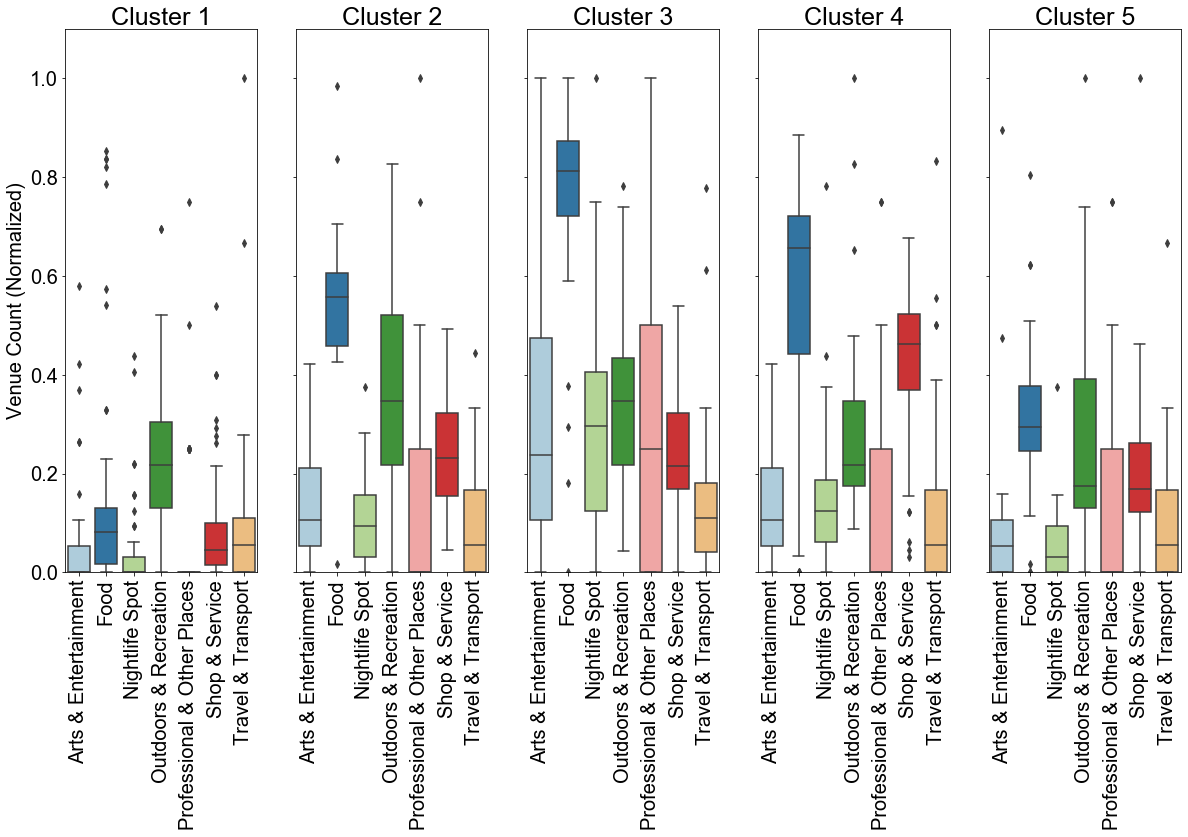

In [67]:
import matplotlib.ticker as ticker 

fig, axes = plt.subplots(1, 5, figsize=(20,10), sharey=True)

axes[0].set_ylabel('Venue Count (Normalized)', fontsize=20)

for k in range(0,5):
    axes[k].set_ylim(0,1.1)
    axes[k].xaxis.set_label_position('top')
    axes[k].set_xlabel('Cluster ' + str(k+1), fontsize=25)
    axes[k].tick_params(labelsize=20)
    plt.sca(axes[k])
    plt.xticks(rotation='vertical')
    condition=df_scaled['Cluster Labels']==k+1
    df_scaled_i=df_scaled[condition]
    df_scaled_i=df_scaled_i[df_scaled_i.columns[~df_scaled_i.columns.isin(['Cluster Labels','Latitude', 'Longitude'])]]
    sns.boxplot(data = df_scaled_i, ax=axes[k])
    sns.set_style("white")
    sns.set_palette("Paired", 7) 

plt.show()

## Results & Discussion

Looking at the boxplots above, we can characterize the clusters according to which type of venues are most prevalent in near the neighborhoods in the two cities. 

- **Cluster 1:** has the lowest number of venues across the board. The neighborhoods in this cluster seem to be areas that are located further away from the city centers; therefore, don't have as many venues as neighborhoods closer to the city centers. It is also worth noting that the most popular venue category in **Cluster 1** is **Outdoors & Recreation**. This could imply that in both cities, living further away from the city center could be best suited for residents that enjoy outdoor activities and don't wish to be disturbed by heavy human traffic in their neighborhoods. 


- **Cluster 2:** has high number of **Food** venues as well as one of the highest number of **Outdoors & Recreation** venues. This cluster seems to group neighborhoods that have a great balance of amenities and infrastructure. Their geographic locations also seem to suggest they are situated just outside of the main city center. Therefore, this cluster could represent residential neighborhoods with many residents that work in the city. Perhaps, the neighborhoods in this cluster could be perfect destination for city commuters that like to enjoy a wide variety of venues closer to their homes. 


- **Cluster 3:** seems to exhibit similar characteristics with slightly less number of venues than **Cluster 2** when looking at the boxplots above. However, when looking at the maps, we can see that **Cluster 3** neighborhoods tend to be located much further away from the city centers. The fact that **Cluster 3** has lower numbers of **Food**, **Nightlife Spot** and **Arts & Entertainment** could imply that **Cluster 3** neighborhoods are more concentrated with residential housing compared to **Cluster 2** neighborhoods. 


- **Cluster 4:** can be characterized by the high number of **Food** and **Shop & Service** venues in the neighborhoods. Looking at the maps, we can see that the neighborhoods are located right outside of the city centers. The neighborhoods in the cluster could be well suited to people that work in the retail business or want to open shops are services after moving to their new neighborhood. 


- **Cluster 5:** definitely can be characterized as the neighborhoods in the city center, indicated by the high number of venues across almost all the categories. The cluster has the highest count of **Food** venues as well as **Professional & Other Services** venues. The map of Austin paints a clear picture of **Cluster 5** being the center of the city. In San Francisco's case, many of neighborhoods near the Union Square have been assigned to **Cluster 5**. The neighborhoods in this cluster are ideal for workers who don't want to commute longer distances to work and want to enjoy the city lifestyle. 

### Hierarchical Agglomerative Clustering Algorithm

The aim of this project was to use machine learning tools to give neighborhood suggestions to residents looking to relocate to a new city. Therefore, we will be using [hierarchical cluster analysis](https://en.wikipedia.org/wiki/Hierarchical_clustering) to generate a dendrogram of all neighborhoods from Austin and San Francisco. 

We use the ward linkage to calculate the distance between the clusters and the Euclidean distance to calculate the shortest distance between the data points. As the choice of these methods will affect the end result of the algorithm. 

The users can look for their current neighborhood in the dendrogram and look for the closest neighborhood of their destination city to find the closest neighborhood based on the types of venues located in the vicinity. 

In [68]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.pairwise import euclidean_distances

venues_counted = venues_onehot.groupby(["City",'Neighborhood'], as_index=False).sum().reset_index(drop=True)

x = venues_counted.drop(["City","Neighborhood"],1).values

mms = MinMaxScaler() 
feature_mtx = mms.fit_transform(x)

dist_matrix = euclidean_distances(feature_mtx,feature_mtx) 

In [69]:
from sklearn.metrics.pairwise import euclidean_distances
import scipy.cluster.hierarchy as shc

Z_using_dist_matrix = shc.linkage(dist_matrix, 'ward')

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: ClusterWarning:

scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix



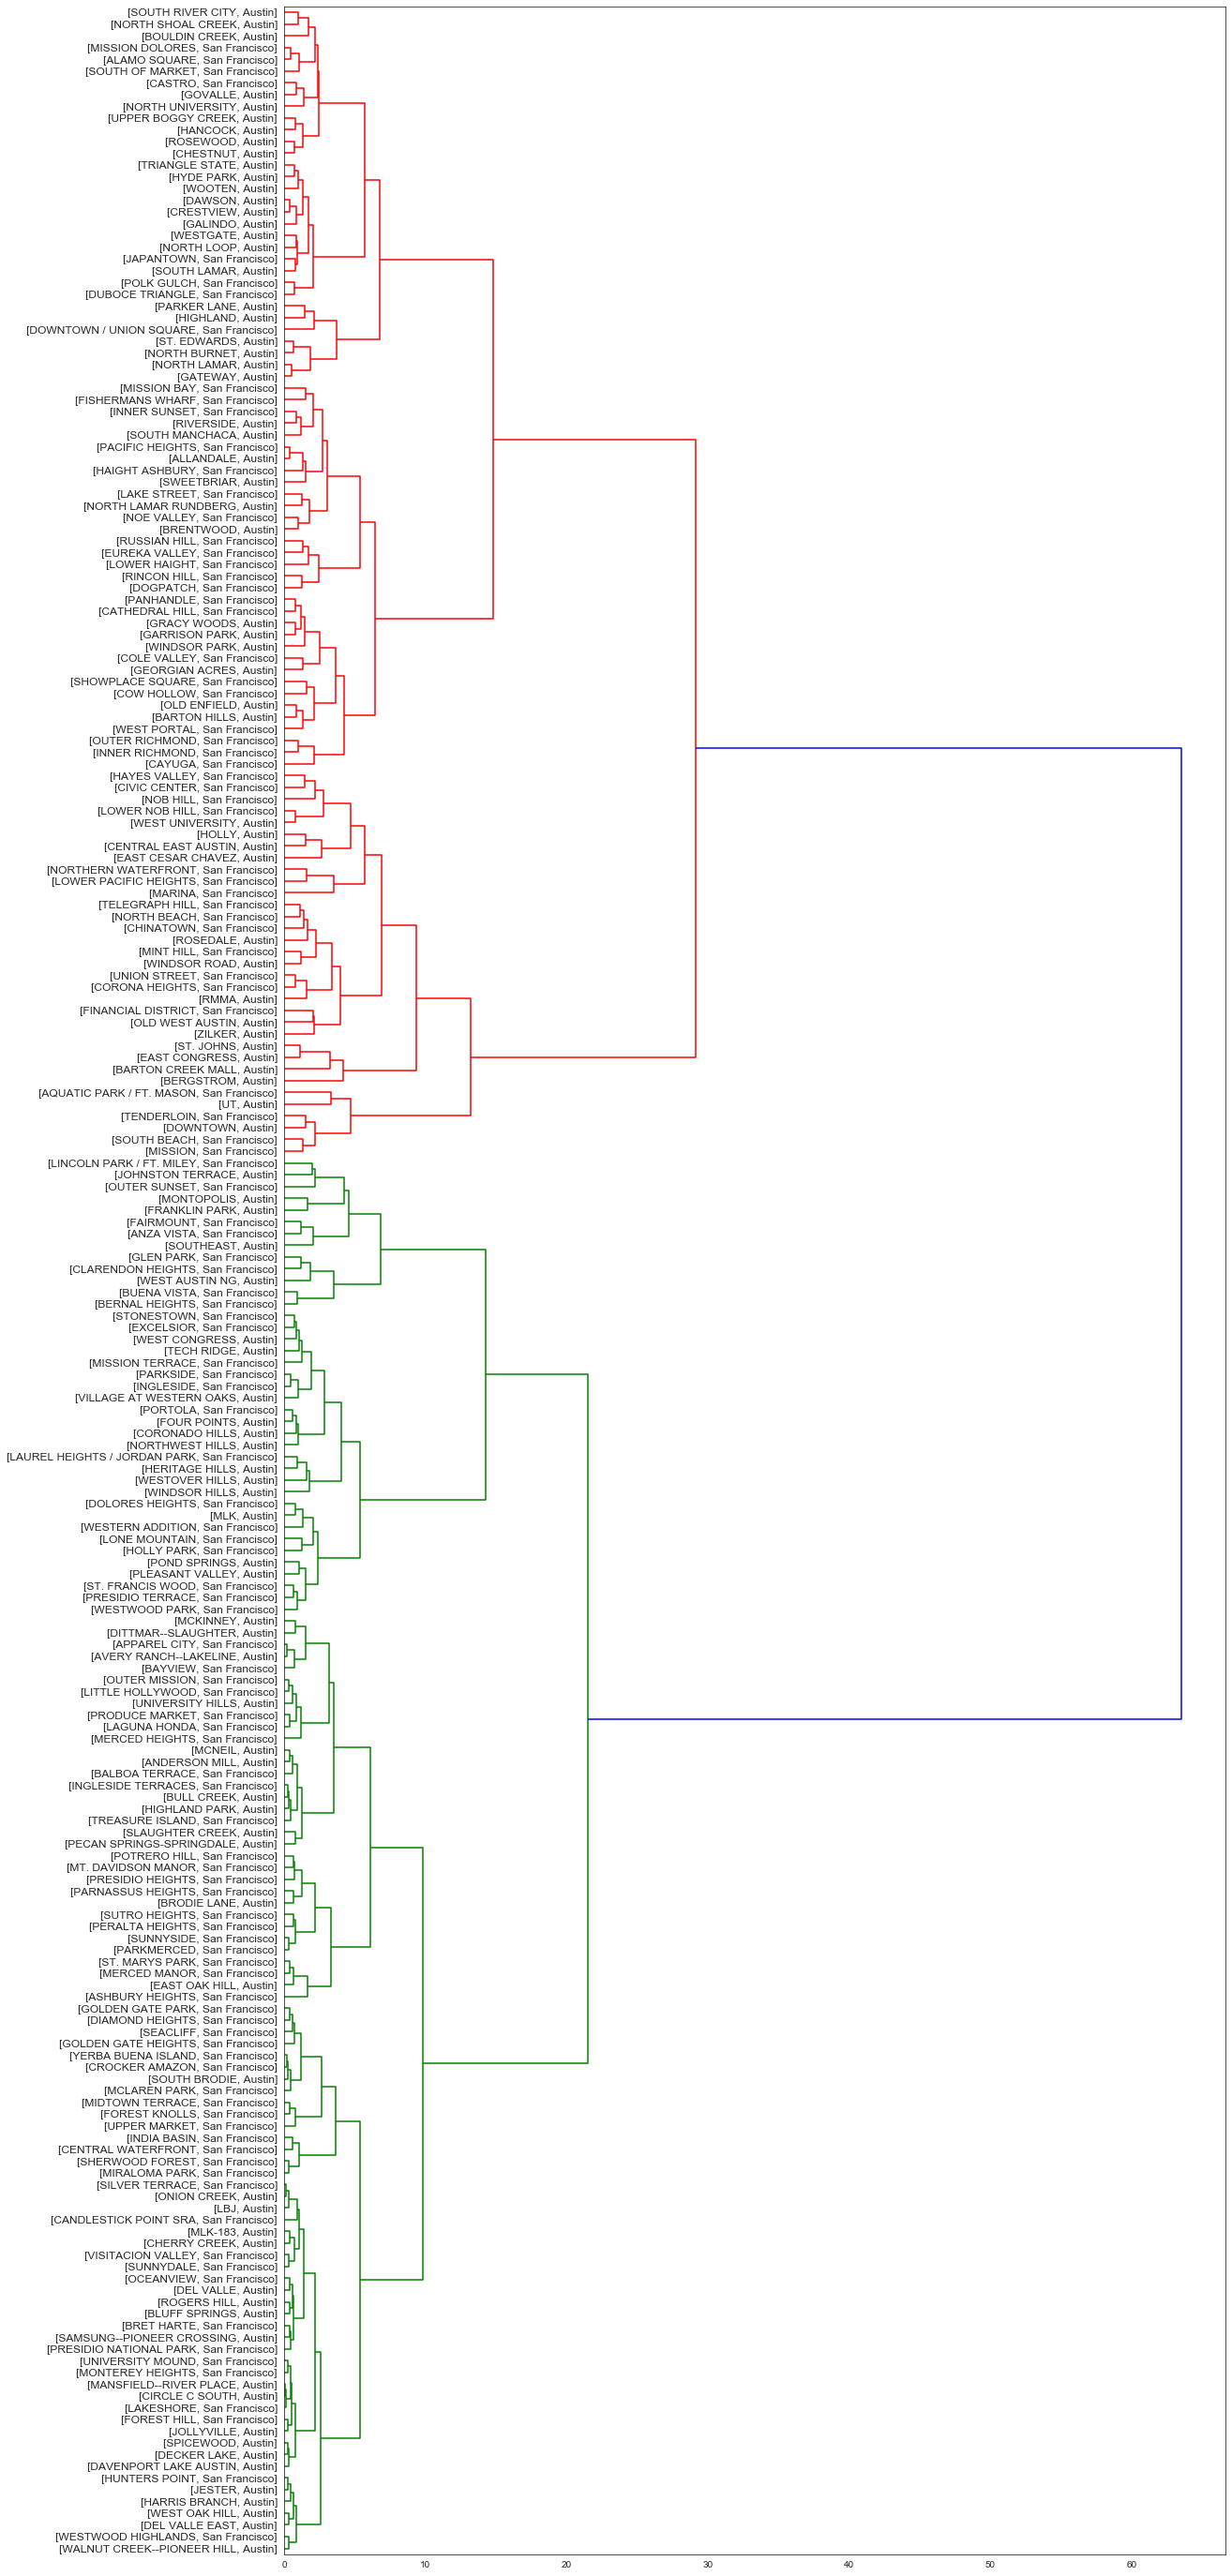

In [70]:
fig = plt.figure(figsize=(18,50))

def llf(id):
    return '[%s, %s]' % (venues_counted['Neighborhood'][id], venues_counted['City'][id])

    
dendro = shc.dendrogram(Z_using_dist_matrix, leaf_label_func=llf, leaf_rotation=0, leaf_font_size =12, orientation = 'right')

## Conclusion

The results from the maps of the clusters and the boxplots show us that the k-means clustering algorithm was successful in grouped similar neighborhoods in Austin and San Francisco. The resulting clustering groups can help people make decisions on which neighborhood to move to when moving from either one of the two cities. 

#### Potential Improvements

Although this investigation has provided us with some useful information, there are many ways in which we can improve our methodology to provide more detailed and accurate analysis for our target audiences. 

- We can add more variables that characterize certain neighborhoods, such as demographics, socioeconomic data, crime rate, housing types, and political orientations. 

- We can also improve the way in which we extract the venues data from Foursquare API by adjusting the radius based on the area of each neighborhood. 

- The investigation could be extended to include other popular cities like New York City, Seattle, and Boston for more comprehensive results for the target audiences. 

- Perhaps using recommendation algorithms to make neighborhood suggestions based on certain neighborhood qualities can be a useful tool for our target audiences. 

